# Optimizing array layout for all-sky radio telescopes using the condition number of the telescope operator

by Tim Molteno (tim@elec.ac.nz)

The discrete sky telescope operator [1] is a linear measurement operator that maps sky-vectors to visibility measurements. This works for arbitrary fields of view, non-coplanar baselines and non-flat skies.

Here we use the condition number of the Moore-Penrose inverse of the telescope operator as an optimization criterion for choosing antenna array layouts.


## Theory

The Moore-Penrose inverse,  $A^+$, (or pseudoinverse) of the telescope operator $A$, maps visibilities to sky-vectors. It can be interpreted as providing the solution, $s$, to the inverse problem $v = A s$, with minimum euclidian norm. Using the SVD of A we can write

$ A = U \Sigma V^H $
or
$ A^H = V \Sigma^H U^H $

and so
$ y = A x = U \Sigma V^H x $
which means:
$ V \Sigma^H U^H y = V \Sigma^H U^H U \Sigma V^H x $, and so

$ V \Sigma^H U^H y = V \Sigma^H \Sigma V^H x $

$A^+ = V \Sigma^+ U^\star$
The condition number of $A^+$ is the ratio between the largest and smallest (non-zero) singular value.

Using the pseudoinverse and a matrix norm, one can define a condition number for any matrix:

\[ cond ( A ) = ‖ A ‖ ‖ A + ‖  \]

A large condition number implies that the problem of finding least-squares solutions to the corresponding system of linear equations is ill-conditioned in the sense that small errors in the entries of A {\displaystyle A} A can lead to huge errors in the entries of the solution.[27] 


The condition number is the radio of the largest to the smallest singular values of the matrix.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Testing the constraining of inputs

The inputs to the optimization function must not allow negative positions along the arms (otherwise the array effectively has six arms). To ensure this we pass the list of radius values through a function that maps all values to positive numbers.

This function must be differentiable so that the gradient of the condition number can be determined.

In [2]:
x = np.linspace(-2,10,100)

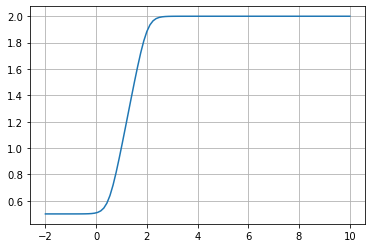

In [3]:
def constrain(x, lower, upper, sharpness=6):
    clip_lower = tf.math.softplus((x-lower)*sharpness)/sharpness + lower
    return upper - tf.math.softplus((-clip_lower + upper)*sharpness)/sharpness

y = constrain(x,0.5,2)
plt.plot(x,y.numpy())
plt.grid(True)

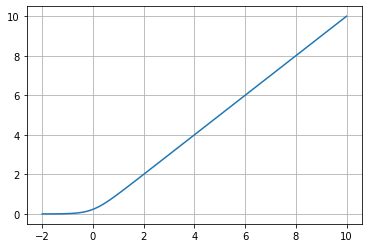

In [4]:
sharpness = 3
y = tf.math.softplus(x*sharpness)/sharpness
plt.plot(x,y.numpy())
plt.grid(True)

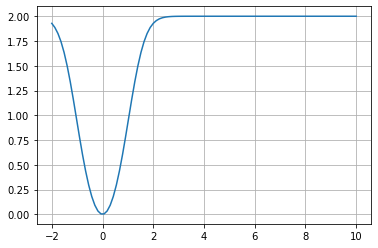

In [5]:
y = (tf.math.sigmoid(x**2)-0.5)*4
plt.plot(x,y.numpy())
plt.grid(True)

Both of these functions do pretty well at mapping all values to between 0..2.  I'll use the softmax version.

## Penalizing antennas that are close together

We need a differentiable function that is nonzero when an antenna pair is closer than some threshold.

In [6]:
def penalize(duv2, limit=0.2):
    sharpness = 50
    duv = tf.sqrt(duv2)
    clip_lower = tf.math.softplus((limit - duv)*sharpness)/sharpness
    return (clip_lower/limit)**2

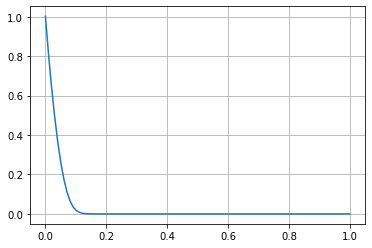

In [7]:
du = np.linspace(0,1,100)
plt.plot(du, penalize(du**2, limit=0.1))
plt.grid(True)

## Optimization Strategy

Tensorflow has recently included the derivative of the SVD operator, so we can compute the gradient of the antenna positions with respect to the condition number!. This is shit hot, and opens up standard optimization strategies to  find optimum array layouts.

### Cost Function

Penalize antennas too close together? 

### Starting Layout

Currently random, but may make sense to start with a perturbed uniform.

## Results

The advantage of using condition number as an optimization criterion is that it provides a quantitative measure of the quality of the inversion that is possible when imaging from the array.

### Choice of Optimizer

We use tensorflow which allows the use of stochastic gradient minimizers that can auto-differentiate the SVD operation. The source code for this strategy is in github [https://github.com/tmolteno/TART-3/tree/master/array/disko_array_opt].

In [8]:
import json
with open('best.json', 'r') as f:
    results = json.load(f)

results['condition_number']

4.486984336339765

In [10]:
import array_opt
ant = array_opt.YAntennaArray.from_json('best.json')

INFO: nside=1 res=3517.9380857010237 arcmin
INFO: nside=2 res=1758.9690428505119 arcmin
INFO: nside=4 res=879.4845214252559 arcmin
INFO: nside=8 res=439.74226071262797 arcmin
INFO: nside=16 res=219.87113035631398 arcmin
INFO: nside=32 res=109.93556517815699 arcmin
INFO: New SubSphere, nside=32
INFO: New SubSphere, nside=32. npix=5056


Text(0.5, 1.0, 'Optimized antenna layout')

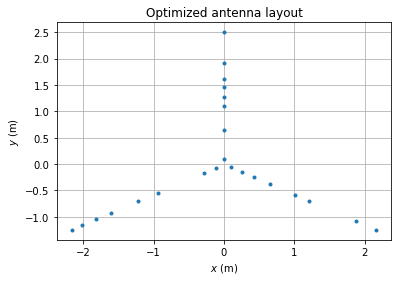

In [19]:
ant_pos = ant.get_ant_pos(ant.arms)
plt.plot(ant_pos[:,0], ant_pos[:,1], '.')
plt.grid(True)
plt.xlabel("$x$ (m)")
plt.ylabel("$y$ (m)")
plt.title('Optimized antenna layout')

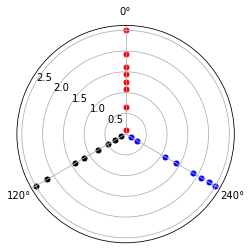

In [36]:
theta = np.zeros_like(ant.arms[0])
angles = (0, 120, 240)
r = ant.arms[0]
area = 25
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.set_thetagrids(angles)
ax.set_rlabel_position(60)
ax.set_theta_zero_location("N")
c0 = ax.scatter(theta, ant.arms[0], c='red', s=area, alpha=1)
c120 = ax.scatter(theta + np.radians(120), ant.arms[1], c='black', s=area, alpha=1)
c240 = ax.scatter(theta + np.radians(240), ant.arms[2], c='blue', s=area, alpha=1)

## Robustness of solutions

There is a reasonable question about how robust the solutions are to small changes in parameters. This will be tested by considering different potential factors

* Pixelization
* Errors in antenna position

### Pixelization 

Pixelization does not appear to change the optimization function much. Starting at a solution with 5000 pixels, and reducing the resolution so that npix=1248 results in a very similar optimium.

    python3 array_opt.py --iter=10000 --fov=160 --arcmin=360 \
        --radius=2.5 --learning-rate=0.001 \
        --initial best.json
        
Increasing the resolution to 90 arc minutes (or 22000 pixels) produces a similar result.

## References

* http://www.math.bas.bg/infres/MathBalk/MB-15/MB-15-035-048.pdf An excellent overview which includes the use of K(A) to deal with Moore-Penrose inverses.
* In https://stanford.edu/~boyd/papers/pdf/diag_scaling_DR_ADMM.pdf we find the interestign statement. Minimization of the pseudo condition numberλmax/λmin>0can be posed as a convex optimization problem and besolved exactly, see [15, Section 6] which also containsheuristics to reduce the pseudo condition number. Reference 15 is ". Giselsson and S. Boyd.  Metric selection in fast dual forwardbackward splitting.Automatica, 2014." see below
* https://web.stanford.edu/~boyd/papers/pdf/metric_select_fdfbs.pdf 